Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In the below section, we create 4 datasets. The first dataset, gender_data, is used for gender classification. The second data set, age_male_data, is used for male/other age classification. The third data set, age_female_data, is used for female age classification. The last dataset is custom_data to determine the age/gender of the custom audio inputs.

In [2]:
#input path to 'full_dataset_label.csv' here ######################################
dataset = "C:/Users/nbard/OneDrive/Documents/Virginia Tech/ECE 4424/final_project/full_dataset_label.csv"

gender_data = pd.read_csv(dataset)
gender_data = gender_data.drop(['age'], axis=1)

age_male_data = pd.read_csv(dataset)
age_male_data = age_male_data.drop(age_male_data[age_male_data['gender'] == 'female'].index)
age_male_data = age_male_data.drop(['gender'], axis=1)

age_female_data = pd.read_csv(dataset)
age_female_data = age_female_data.drop(age_female_data[age_female_data['gender'] == 'male'].index)
age_female_data = age_female_data.drop(['gender'], axis=1)

#input path to custom audio input here ############################################
custom_data = pd.read_csv("C:/Users/nbard/OneDrive/Documents/Virginia Tech/ECE 4424/final_project/custom_input.csv")
custom_data_gender = custom_data.drop(['age'], axis=1)

The below section will create a chart displaying the counts of each age grouping for each gender.

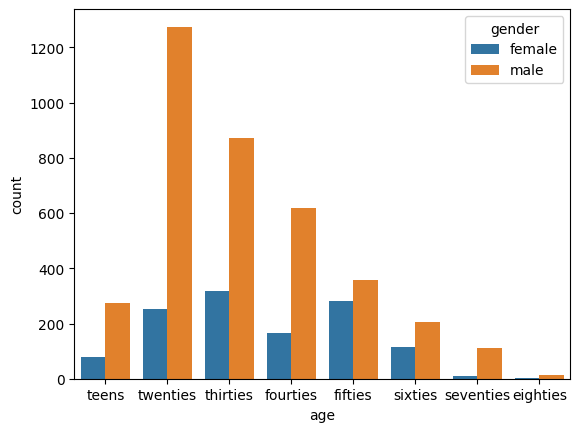

In [3]:
plot = pd.read_csv(dataset)
sns.countplot(x="age", 
        hue='gender',
        data=plot[plot['age'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

After completing the initial data transformation, we need to update the labels for age and gender to numerical labels. This is for the fit and transform algorithms, as well as the SVM implementation of sklearn.

In [4]:
gender_data['gender'].replace('female', 1, inplace=True)
gender_data['gender'].replace('male', 2, inplace=True)

age_male_data['age'].replace('teens', 1, inplace=True)
age_male_data['age'].replace('twenties', 2, inplace=True)
age_male_data['age'].replace('thirties', 3, inplace=True)
age_male_data['age'].replace('fourties', 4, inplace=True)
age_male_data['age'].replace('fifties', 5, inplace=True)
age_male_data['age'].replace('sixties', 6, inplace=True)
age_male_data['age'].replace('seventies', 7, inplace=True)
age_male_data['age'].replace('eighties', 8, inplace=True)

age_female_data['age'].replace('teens', 1, inplace=True)
age_female_data['age'].replace('twenties', 2, inplace=True)
age_female_data['age'].replace('thirties', 3, inplace=True)
age_female_data['age'].replace('fourties', 4, inplace=True)
age_female_data['age'].replace('fifties', 5, inplace=True)
age_female_data['age'].replace('sixties', 6, inplace=True)
age_female_data['age'].replace('seventies', 7, inplace=True)
age_female_data['age'].replace('eighties', 8, inplace=True)

After we finish the data transformation, we split the data set into an X and Y dataset, with X containing the features, and Y containing the labels. This is done for each data set.

In [5]:
X = gender_data.drop(['gender'], axis=1)
Y = gender_data['gender']

X2 = age_male_data.drop(['age'], axis=1)
Y2 = age_male_data['age']

X3 = age_female_data.drop(['age'], axis=1)
Y3 = age_female_data['age']

custom_X_gender = custom_data_gender.drop(['gender'], axis=1)


After obtaining the X and Y of each dataset, we split each X and Y into train and test data sets with a 70/30 split. 

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.3, random_state = 42)
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size = 0.3, random_state = 42)

The code below standardizes the features of the data with the StandardScaler class from scikit-learn. It normalizes each data point and updates the average to 0 with a standard deviation of 1. This allows sklearn's algorithms to better compare data points with their newly scaled features.

In [7]:
def standardize_data(train_data, test_data):
    cols = train_data.columns
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    train_data_scaled = pd.DataFrame(train_data_scaled, columns=cols)
    
    test_data_scaled = scaler.transform(test_data)
    test_data_scaled = pd.DataFrame(test_data_scaled, columns=cols)
    
    return train_data_scaled, test_data_scaled

X_train, X_test = standardize_data(X_train, X_test)
X2_train, X2_test = standardize_data(X2_train, X2_test)
X3_train, X3_test = standardize_data(X3_train, X3_test)

scaler2 = StandardScaler()
custom_standard_x_gender = pd.DataFrame(scaler2.fit_transform(custom_X_gender), columns=custom_X_gender.columns)

Create two python functions tolerance_accuracy and train_and_evaluate_model. tolerance_accuracy measures the updated accuracy of the age bins. train_and_evaluate_model fits the data and then predicts the labels.

In [8]:
def tolerance_accuracy(y_true, y_pred, tolerance):
    correct = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) <= tolerance:
            correct += 1
    return correct / len(y_true)

def train_and_evaluate_model(model, X_train, Y_train, X_test, Y_test, tolerance=None, accuracy_fn=accuracy_score):
    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    Y_test = np.asarray(Y_test)
    
    if tolerance is not None:
        accuracy = accuracy_fn(Y_test, Y_pred_test, tolerance) * 100
    else:
        accuracy = accuracy_fn(Y_test, Y_pred_test) * 100
        
    return accuracy

Run SVM models, one for gender, one for male age, and one for female age. Trains on train data and predicts on test data. Creates dictionaries to replace numeric values with correct labels. Prints out classification for each custom input in addition to the overall gender and age accuracies.

In [9]:
age_tolerance = 1
gender_model = SVC(kernel='rbf', C=1) 
age_male_model = SVC(kernel='rbf', C=1)
age_female_model = SVC(kernel='rbf', C=1)

gender_accuracy = train_and_evaluate_model(gender_model, X_train, Y_train, X_test, Y_test)
age_male_accuracy = train_and_evaluate_model(age_male_model, X2_train, Y2_train, X2_test, Y2_test, age_tolerance, tolerance_accuracy)
age_female_accuracy = train_and_evaluate_model(age_female_model, X3_train, Y3_train, X3_test, Y3_test, age_tolerance, tolerance_accuracy)

gender_dict = {1: 'female', 2: 'male'}
age_dict = {1: 'teens', 2: 'twenties', 3: 'thirties', 4: 'fourties', 5: 'fifties', 6: 'sixties', 7: 'seventies', 8: 'eighties'}

custom_predict_y_gender = []
custom_predict_y_age = []

for i in range(len(custom_standard_x_gender)):
    curr_sample = custom_standard_x_gender.iloc[[i]]
    curr_predict_gender = gender_model.predict(curr_sample)

    custom_predict_y_gender.append(curr_predict_gender[0])
    
    if(curr_predict_gender[0] == 1):
        curr_predict_age = age_female_model.predict(curr_sample)
    else:
        curr_predict_age = age_male_model.predict(curr_sample)
        
    custom_predict_y_age.append(curr_predict_age[0])
    
    output_y = (age_dict[curr_predict_age[0]], gender_dict[curr_predict_gender[0]])

    print("Classification for custom input", i, ": ", output_y)

print()
print('Gender Classification Model\nAccuracy: {:0.4f}%'.format(gender_accuracy))
print()
print('Age Classification Model\nMale Accuracy with tolerance {}: {:0.4f}%'.format(age_tolerance, age_male_accuracy))
print('Female Accuracy with tolerance {}: {:0.4f}%'.format(age_tolerance, age_female_accuracy))

Classification for custom input 0 :  ('twenties', 'male')
Classification for custom input 1 :  ('twenties', 'male')
Classification for custom input 2 :  ('twenties', 'male')
Classification for custom input 3 :  ('twenties', 'male')
Classification for custom input 4 :  ('thirties', 'female')
Classification for custom input 5 :  ('twenties', 'female')
Classification for custom input 6 :  ('twenties', 'female')
Classification for custom input 7 :  ('thirties', 'male')

Gender Classification Model
Accuracy: 92.2559%

Age Classification Model
Male Accuracy with tolerance 1: 68.4540%
Female Accuracy with tolerance 1: 69.3989%


The code below is our implementation of RandomForestClassifier with a list of possible numbers of estimators that will be looped through to compare the accuracy using the different values, which will be stored in accuracy_list. For every iteration, three RandomForestClassifiers are created: gender_model, age_male_model, and age_female_model. The models are trained using train_and_evaluate_model. Results are printed with current number of estimators, the gender classifcation model accuracy, and the age classification model accuracy with age tolerance for both male and female.

In [10]:
poss_n_estimators = [1, 5, 10, 50, 100, 500, 1000]

accuracy_list = []

for n in poss_n_estimators:
    gender_model = RandomForestClassifier(n_estimators=n, random_state=42)
    age_male_model = RandomForestClassifier(n_estimators=n, random_state=42)
    age_female_model = RandomForestClassifier(n_estimators=n, random_state=42)

    gender_accuracy = train_and_evaluate_model(gender_model, X_train, Y_train, X_test, Y_test)
    age_male_accuracy = train_and_evaluate_model(age_male_model, X2_train, Y2_train, X2_test, Y2_test, age_tolerance, tolerance_accuracy)
    age_female_accuracy = train_and_evaluate_model(age_female_model, X3_train, Y3_train, X3_test, Y3_test, age_tolerance, tolerance_accuracy)
       
    print('N-Estimators: {}'.format(n))
    print()
    
    for i in range(len(custom_standard_x_gender)):
        curr_sample = custom_standard_x_gender.iloc[[i]]
        curr_predict_gender = gender_model.predict(curr_sample)

        custom_predict_y_gender.append(curr_predict_gender[0])
        
        if(curr_predict_gender[0] == 1):
            curr_predict_age = age_female_model.predict(curr_sample)
        else:
            curr_predict_age = age_male_model.predict(curr_sample)
            
        custom_predict_y_age.append(curr_predict_age[0])
        
        output_y = (age_dict[curr_predict_age[0]], gender_dict[curr_predict_gender[0]])

        print("Classification for custom input", i, ": ", output_y)
        
    print()
    print('Gender Classification Model\nAccuracy: {:0.4f}%'.format(gender_accuracy))
    print()
    print('Age Classification Model\nMale Accuracy with tolerance {}: {:0.4f}%'.format(age_tolerance, age_male_accuracy))
    print('Female Accuracy with tolerance {}: {:0.4f}%'.format(age_tolerance, age_female_accuracy))
    print()
    print()

N-Estimators: 1

Classification for custom input 0 :  ('twenties', 'male')
Classification for custom input 1 :  ('twenties', 'male')
Classification for custom input 2 :  ('twenties', 'male')
Classification for custom input 3 :  ('teens', 'male')
Classification for custom input 4 :  ('twenties', 'female')
Classification for custom input 5 :  ('fourties', 'female')
Classification for custom input 6 :  ('teens', 'female')
Classification for custom input 7 :  ('teens', 'female')

Gender Classification Model
Accuracy: 86.5993%

Age Classification Model
Male Accuracy with tolerance 1: 54.9598%
Female Accuracy with tolerance 1: 56.5574%


N-Estimators: 5

Classification for custom input 0 :  ('twenties', 'male')
Classification for custom input 1 :  ('twenties', 'male')
Classification for custom input 2 :  ('fourties', 'male')
Classification for custom input 3 :  ('teens', 'male')
Classification for custom input 4 :  ('twenties', 'female')
Classification for custom input 5 :  ('fourties', 'fem